In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve,r2_score
from sklearn.preprocessing import StandardScaler



DATASET OVERVIEW


In [3]:
df=pd.read_csv("car_sales_data.csv")
print(df.head(),"\n\n\n",df.shape)

  Manufacturer       Model  Engine size Fuel type  Year of manufacture  \
0         Ford      Fiesta          1.0    Petrol                 2002   
1      Porsche  718 Cayman          4.0    Petrol                 2016   
2         Ford      Mondeo          1.6    Diesel                 2014   
3       Toyota        RAV4          1.8    Hybrid                 1988   
4           VW        Polo          1.0    Petrol                 2006   

   Mileage  Price  
0   127300   3074  
1    57850  49704  
2    39190  24072  
3   210814   1705  
4   127869   4101   


 (50000, 7)


In [4]:
print(df.info(),"\n\n\n",df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB
None 


         Engine size  Year of manufacture        Mileage          Price
count  50000.000000         50000.000000   50000.000000   50000.000000
mean       1.773058          2004.209440  112497.320700   13828.903160
std        0.734108             9.645965   71632.515602   16416.681336
min        1.000000          1984.000000     630.000000      76.000000
25%        1.400

EDA and FEATURE ENGINEERING



In [5]:
df["AGE"]=2025-df["Year of manufacture"]
df.drop("Year of manufacture",axis=1,inplace=True)
df.head()

,Manufacturer,Model,Engine size,Fuel type,Mileage,Price,AGE
0,Ford,Fiesta,1.0,Petrol,127300,3074,23
1,Porsche,718 Cayman,4.0,Petrol,57850,49704,9
2,Ford,Mondeo,1.6,Diesel,39190,24072,11
3,Toyota,RAV4,1.8,Hybrid,210814,1705,37
4,VW,Polo,1.0,Petrol,127869,4101,19


In [6]:
df['Fuel type'].unique()

array(['Petrol', 'Diesel', 'Hybrid'], dtype=object)

In [7]:
df['Fuel type']=df['Fuel type'].map({'Petrol':0,'Diesel':1,'Hybrid':2})

df.head()

,Manufacturer,Model,Engine size,Fuel type,Mileage,Price,AGE
0,Ford,Fiesta,1.0,0,127300,3074,23
1,Porsche,718 Cayman,4.0,0,57850,49704,9
2,Ford,Mondeo,1.6,1,39190,24072,11
3,Toyota,RAV4,1.8,2,210814,1705,37
4,VW,Polo,1.0,0,127869,4101,19


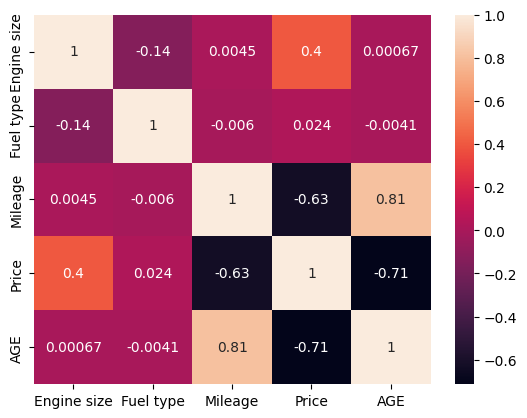

In [8]:
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

NOW WE'LL FIND HIGH CORRELATION COLUMNS FOR TO SHOW ON GRAPH


In [9]:
def highCorr(df,threshold=0.8):
    highCorrPairs=[]
    corr_matrix=df.corr(numeric_only=True)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                highCorrPairs.append(corr_matrix.columns[i])
                highCorrPairs.append(corr_matrix.columns[j])
    return highCorrPairs
    

In [10]:
myPairs=highCorr(df,0.65)
myPairs

['AGE', 'Mileage', 'AGE', 'Price']

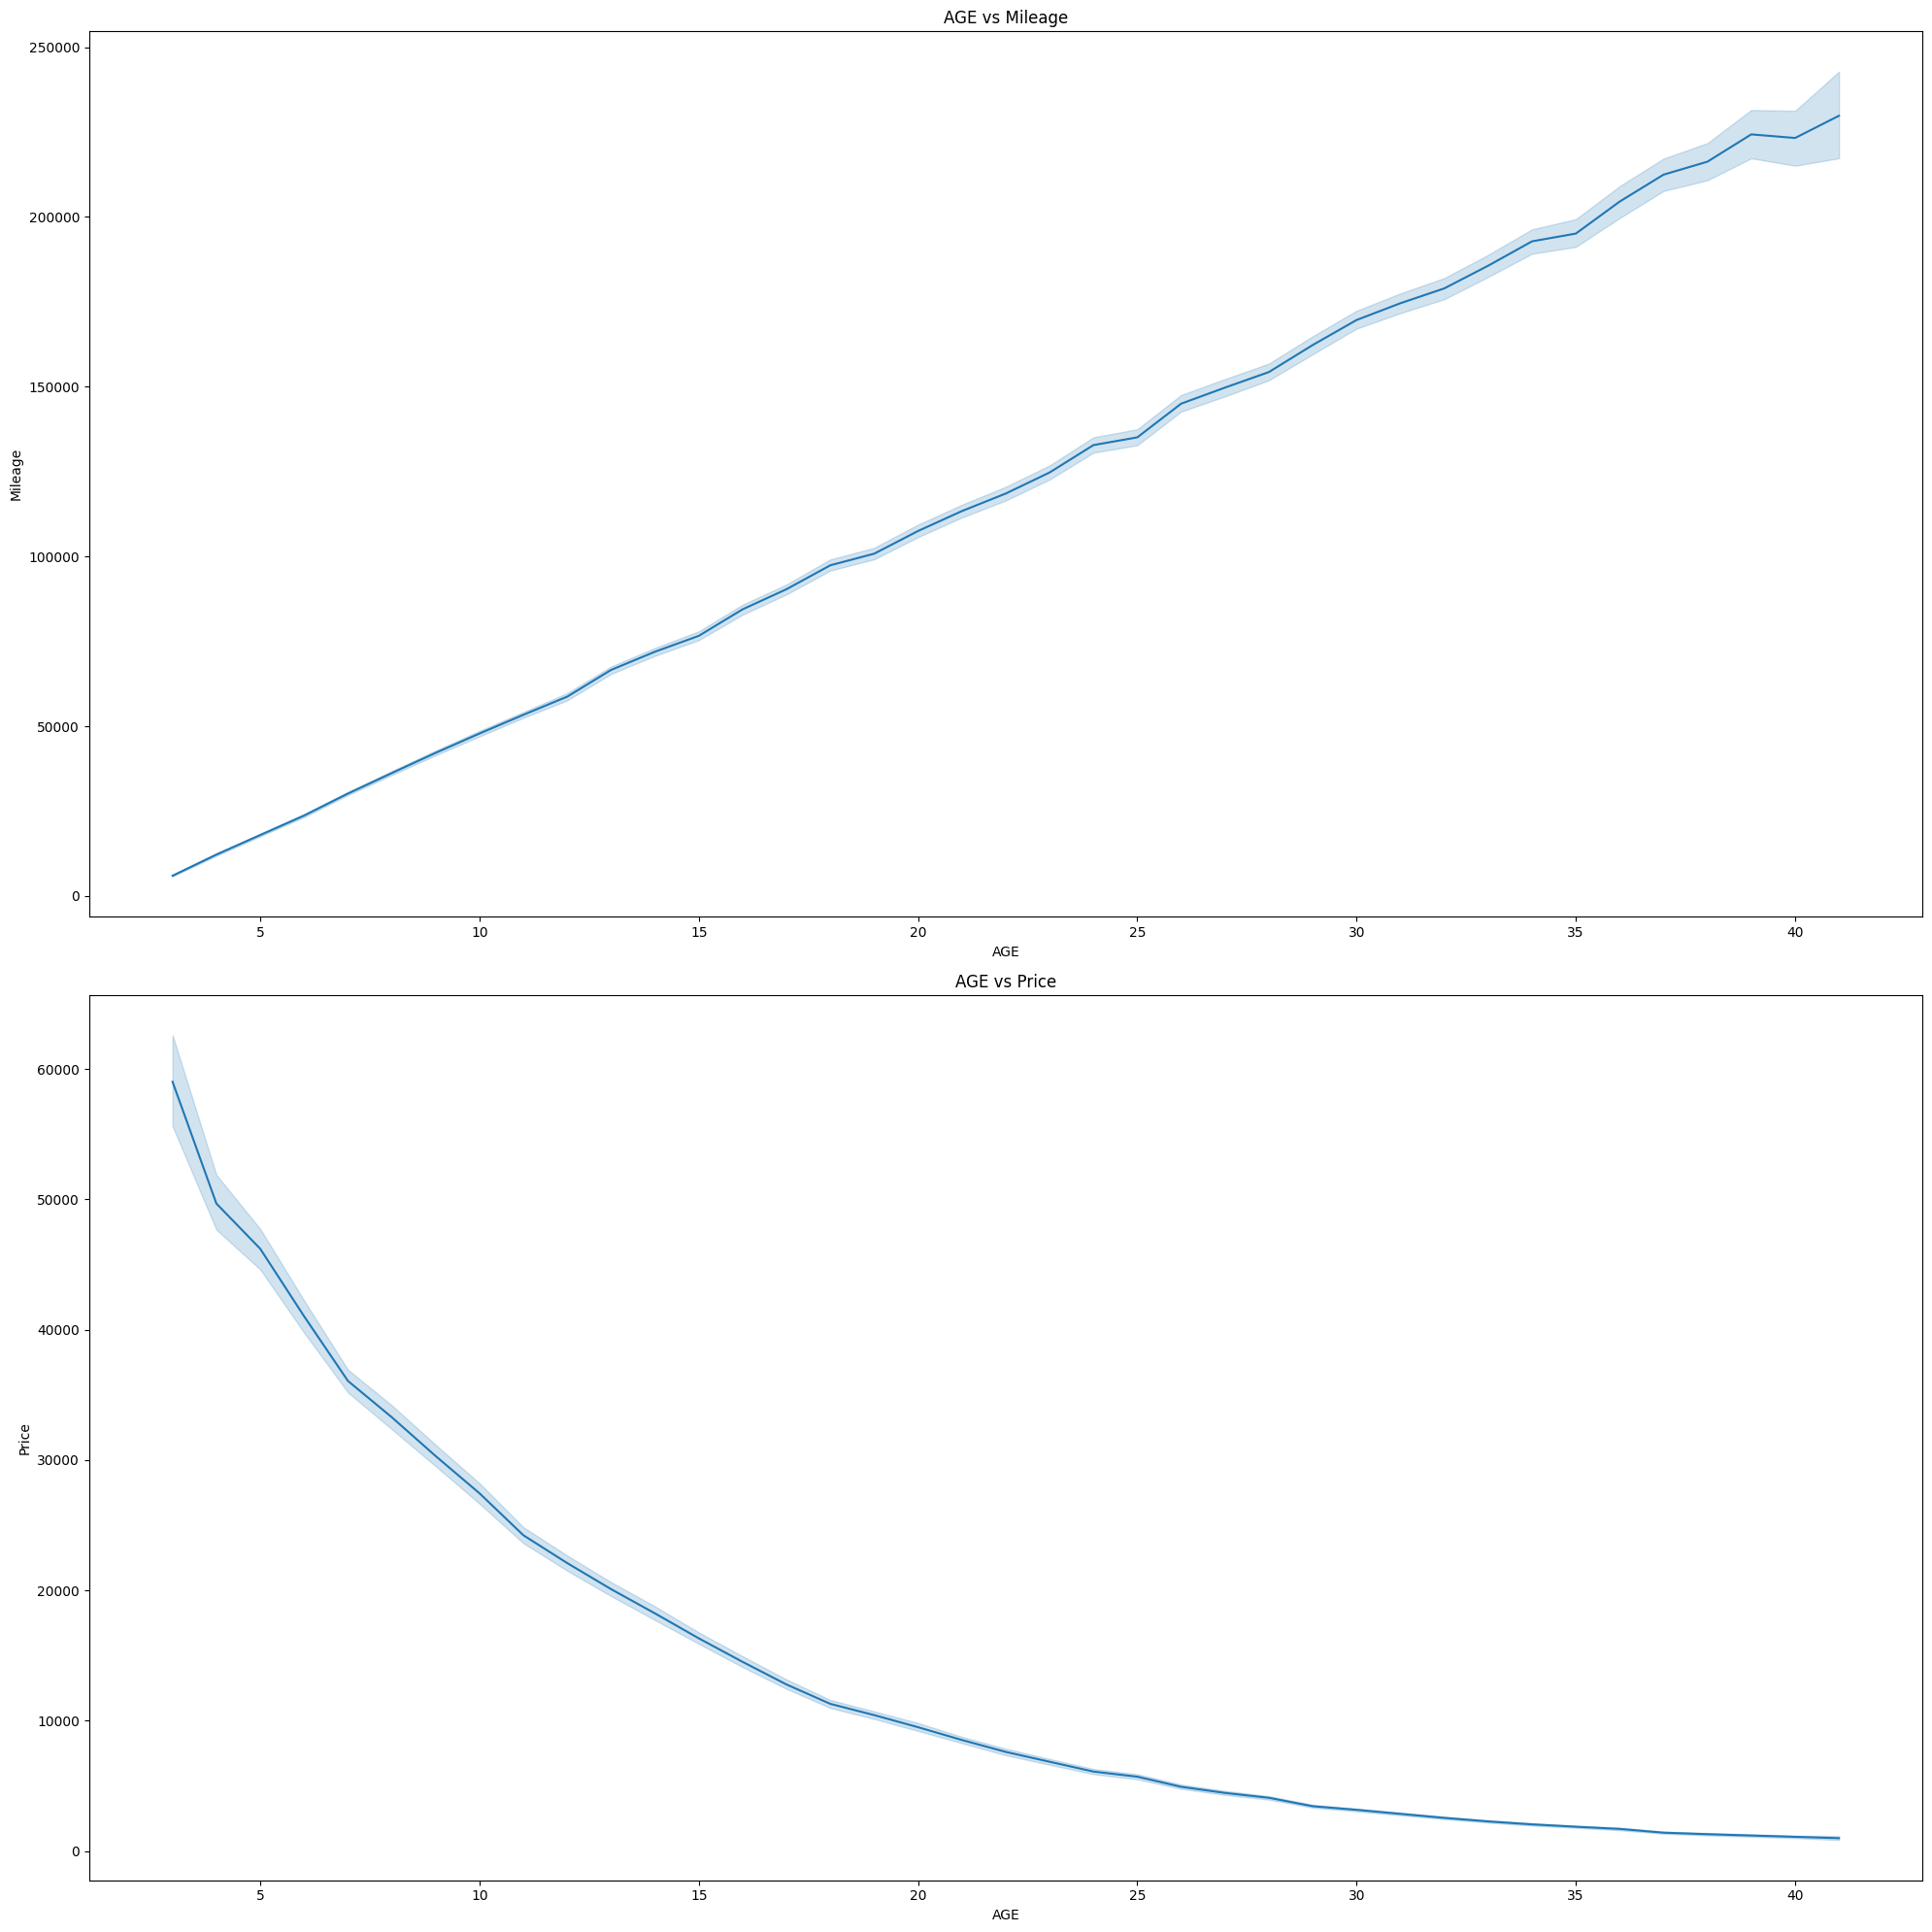

In [11]:
fig,ax=plt.subplots(2,1,figsize=(20,5*len(myPairs)))
ax=ax.flatten()

for i in range(0,len(myPairs),2):
    sns.lineplot(data=df,x=myPairs[i],y=myPairs[i+1],ax=ax[i//2])
    ax[i//2].set_title(f"{myPairs[i]} vs {myPairs[i+1]}")
    plt.tight_layout()
plt.show()

MODEL COUNTS BY MANUFACTURERS

In [12]:
models_buy_manufacturer=df['Model'].groupby(df['Manufacturer']).count().sort_values(ascending=False)
models_buy_manufacturer=models_buy_manufacturer.reset_index()

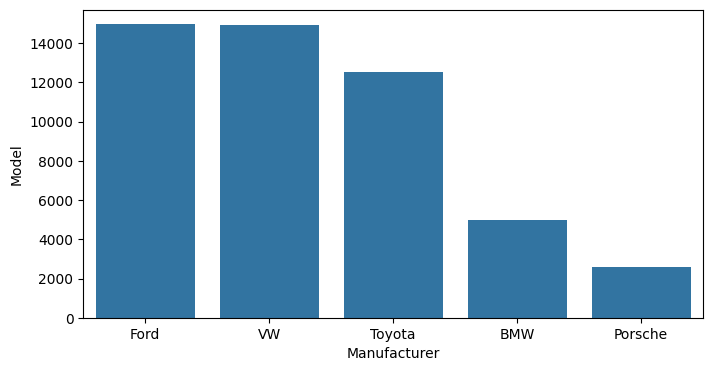

In [13]:
plt.figure(figsize=(8,4))
sns.barplot(x=models_buy_manufacturer['Manufacturer'],y=models_buy_manufacturer['Model'])
plt.show()

ENGINE SIZE BY MODELS COUNT


In [14]:
engineSize_by_model=df['Model'].groupby(df['Engine size'])
engineSize_by_model=engineSize_by_model.value_counts().reset_index().groupby('Engine size',as_index=False)['count'].sum()
engineSize_by_model


,Engine size,count
0,1.0,6343
1,1.2,4984
2,1.4,10060
3,1.6,5509
4,1.8,7032
5,2.0,7631
6,2.2,1678
7,2.4,2364
8,2.6,448
9,3.0,1368


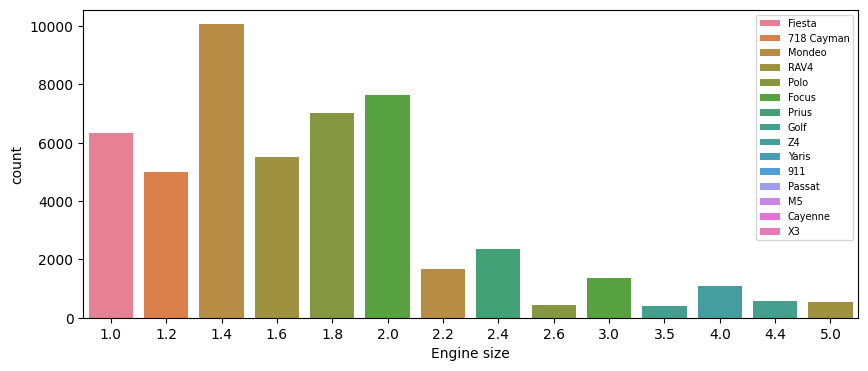

In [15]:
plt.figure(figsize=(10,4))
sns.barplot(x=engineSize_by_model['Engine size'],y=engineSize_by_model['count'],hue=df['Model'])
plt.legend(fontsize=7)
plt.show()

MODEL TRAINING

WE'LL FIND THE PRICE CHANGING ACOORDING TO OTHER COLUMNS


LET CHECK FOR OUTLIERS

In [16]:
df.drop(columns=['Manufacturer','Model'],axis=1,inplace=True)

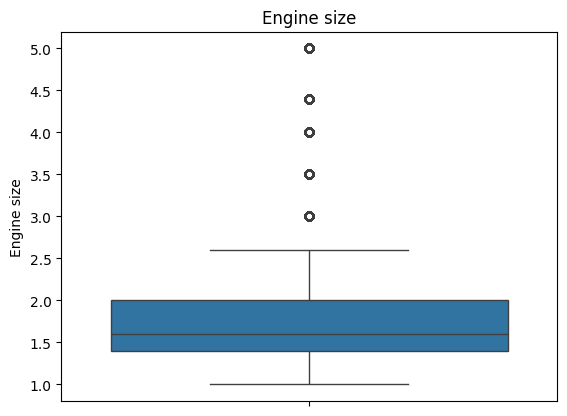

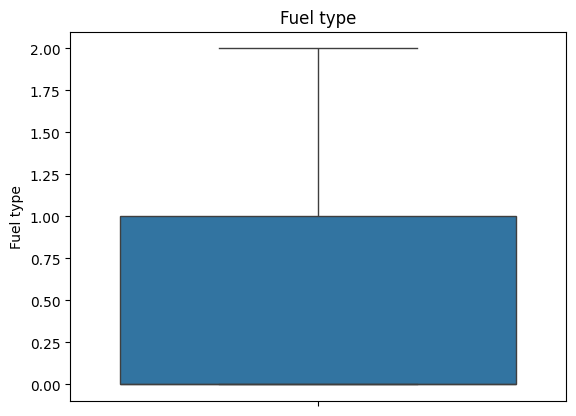

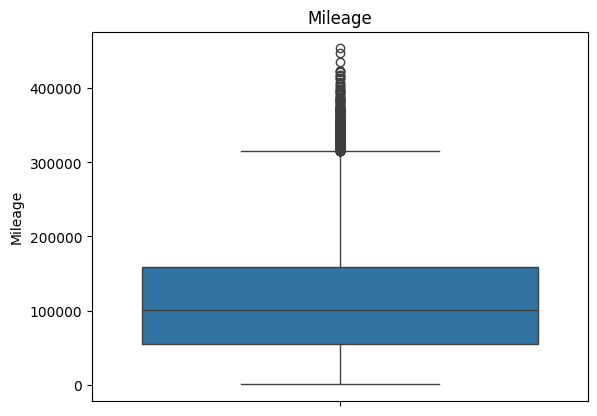

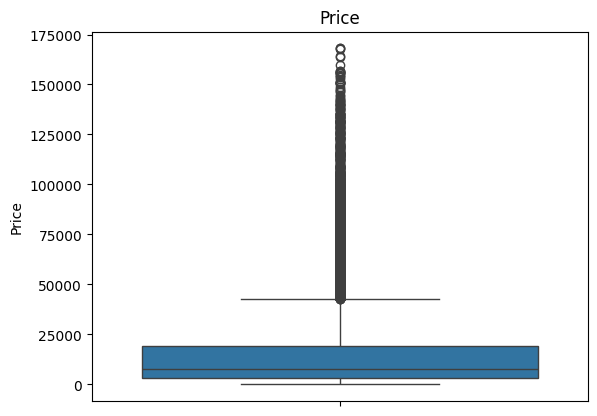

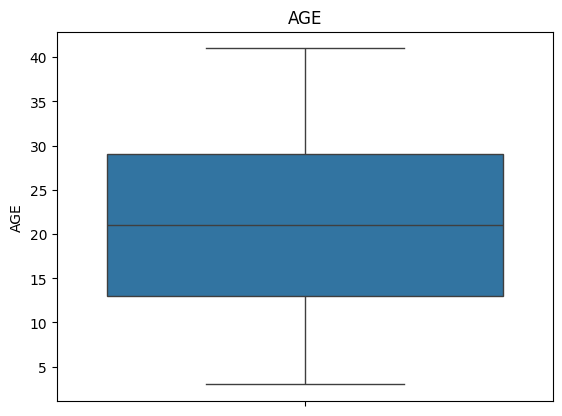

In [17]:
for col in df.columns:
    
    sns.boxplot(df[col])
    plt.title(f"{col}")
    plt.show()

FIX OUTLIERS BY STANDART SCALER BUT AT FIRST WE SHOULD SEPERATE DATAFRAME TO TRAIN AND TEST
 

OUR GOAL IS TRAIN AND CLASS THE PRICE CHANGING ACCORDING TO COLUMNS

In [18]:
X=df.drop('Price',axis=1)
y=df['Price']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.22,random_state=21)


In [19]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

print(X_train[0:4],"\n\n",X_test[0:4])

[[-0.23606494 -0.88239484  0.36879636 -0.28709869]
 [ 0.03584305 -0.88239484 -0.65639273 -0.49446695]
 [ 0.03584305  1.59445839 -1.30415501 -0.28709869]
 [ 0.30775104  0.35603178  1.07543722  2.09763627]] 

 [[-0.77988093  1.59445839 -0.99817369 -0.90920347]
 [-0.50797293  0.35603178 -0.69093428 -0.80551934]
 [-0.23606494  0.35603178  1.5643028   1.06079498]
 [-0.77988093 -0.88239484  0.83118615  1.57921563]]


WE'LL FIND THE BEST CLASSIFIER 


In [ ]:
X_train=X_train.astype('float32')
lr=LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
confusion=confusion_matrix(y_test,y_pred)
report=classification_report(y_test,y_pred)
print("Accuracy: ",accuracy,"\n\n\nConfusion Matrix: \n\n",confusion,"\n\n\nClassification Report: ",report)